<a href="https://colab.research.google.com/github/SumeetChougule/PM-HR/blob/main/experiments/Force_correction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Git clone

In [ ]:
!git clone https://github.com/DifferentiableUniverseInitiative/flowpm.git
!pip install git+https://github.com/DifferentiableUniverseInitiative/flowpm.git

Cloning into 'flowpm'...
remote: Enumerating objects: 3470, done.
remote: Counting objects: 100% (1315/1315), done.
remote: Compressing objects: 100% (464/464), done.
remote: Total 3470 (delta 855), reused 1228 (delta 831), pack-reused 2155
Receiving objects: 100% (3470/3470), 65.55 MiB | 14.55 MiB/s, done.
Resolving deltas: 100% (2284/2284), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/DifferentiableUniverseInitiative/flowpm.git to /tmp/pip-req-build-0mnwyuej
  Running command git clone -q https://github.com/DifferentiableUniverseInitiative/flowpm.git /tmp/pip-req-build-0mnwyuej
     |████████████████████████████████| 385 kB 4.7 MB/s 
     |████████████████████████████████| 221 kB 48.4 MB/s 
     |████████████████████████████████| 1.1 MB 62.5 MB/s 
  Created wheel for flowpm: filename=flowpm-0.1.2.dev252+g8f9415b-py3-none-any.whl size=45196 sha256=4a029ae0e8aabd4152ea00771a891b7b3022e7322dc1760261

## Modules

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras.layers as tfl
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
from tensorflow.keras import datasets, layers, models, losses

import tensorflow_probability as tfp
tfd = tfp.distributions

import flowpm
from astropy.cosmology import Planck15
from flowpm import linear_field, lpt_init, nbody, cic_paint, cic_readout
from flowpm.utils import r2c3d, c2r3d

from scipy.interpolate import InterpolatedUnivariateSpline as iuspline


## Input data from PM


In [145]:
bs, nc = 100, 32
nsteps = 5
a0, af, nsteps = 0.1, 1.0,  nsteps
stages = np.linspace(a0, af, nsteps, endpoint=True)
donbody = False
dnoise = 1. #0.1
b_size = 1

klin, plin = np.loadtxt('flowpm/flowpm/data/Planck15_a1p00.txt').T
ipklin = iuspline(klin, plin)

In [141]:
batchs =3
state_b = []
fin_b   = [] 
pos_b   = []
for i in range(batchs):
  @tf.function
  def pm(linear):
    print("PM graph")
    cosmo = flowpm.cosmology.Planck15()
    state = lpt_init(cosmo, linear, a=a0, order=2)
    final_state = nbody(cosmo, state,  stages, nc, return_intermediate_states=False)
    tfinal_field = cic_paint(tf.zeros_like(linear), final_state[0])
    return final_state, tfinal_field

  ic = linear_field(nc, bs, ipklin, batch_size = b_size, name='pm').numpy()
  state, fin = pm(tf.constant(ic))
  pos = state[0].numpy()
  state_b.append(state)
  fin_b.append(fin)
  pos_b.append(pos)


PM graph
PM graph
PM graph


In [166]:
fin_b[2][0].shape

TensorShape([32, 32, 32])

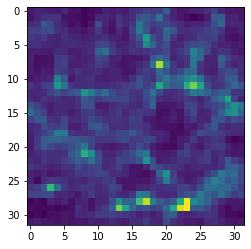

In [168]:
plt.imshow(fin_b[2][0].numpy().sum(axis=0))

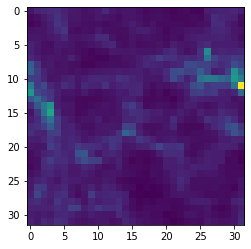

In [48]:
# Model trained on this distribution of 32^3 particles
plt.imshow(fin[0].numpy().sum(axis=0))

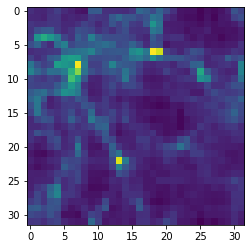

In [50]:
plt.imshow(fin[np.random.randint(2)].numpy().sum(axis=0))

### Helper functions

In [169]:
def cic_readout_features(mesh, part, name="CiCReadout"):
  """
  Reads out particles from mesh.
  Parameters: 
  ----------- 
  mesh: tensor (batch_size, nc, nc, nc, T)
      Input 4D mesh tensor with last axis of T features
  
  part: tensor (batch_size, npart, 3)
      List of 3D particle coordinates, assumed to be in mesh units if
  boxsize is None
  
  Return:
  -------
  value: tensor (batch_size, npart) 
      Value of the field sampled at the particle locations
  """
  with tf.name_scope("CiCReadoutFeatures"):
    mesh = tf.convert_to_tensor(mesh, name="mesh")
    part = tf.convert_to_tensor(part, name="part")

    shape = tf.shape(mesh)
    batch_size, nx, ny, nz = shape[0], shape[1], shape[2], shape[3]
    nc = [nx, ny, nz]

    # Flatten part if it's not already done                                                                                                                                                                                                                                                                                   
    if len(part.shape) > 3:
      part = tf.reshape(part, (batch_size, -1, 3))

    # Extract the indices of all the mesh points affected by each particles                                                                                                                                                                                                                                                   
    part = tf.expand_dims(part, 2)
    floor = tf.floor(part)
    connection = tf.expand_dims(
        tf.constant([[[0, 0, 0], [1., 0, 0], [0., 1, 0], [0., 0, 1],
                      [1., 1, 0], [1., 0, 1], [0., 1, 1], [1., 1, 1]]]), 0)

    neighboor_coords = tf.add(floor, connection)
    kernel = 1. - tf.abs(part - neighboor_coords)
    kernel = kernel[..., 0] * kernel[..., 1] * kernel[..., 2]

    neighboor_coords = tf.cast(neighboor_coords, tf.int32)
    neighboor_coords = tf.math.mod(neighboor_coords, nc)

    meshvals = tf.gather_nd(mesh, neighboor_coords, batch_dims=1)
    weightedvals = tf.multiply(meshvals, tf.expand_dims(kernel, -1))
    value = tf.reduce_sum(weightedvals, axis=-2)
    return value

def fftk(shape, symmetric=True, finite=False, dtype=np.float64):
    """ Return k_vector given a shape (nc, nc, nc) and box_size                                                                                                                                                                                                                                                                 
    """
    k = []
    for d in range(len(shape)):
        kd = np.fft.fftfreq(shape[d])
        kd *= 2 * np.pi
        kdshape = np.ones(len(shape), dtype='int')
        if symmetric and d == len(shape) - 1:
            kd = kd[:shape[d] // 2 + 1]
        kdshape[d] = len(kd)
        kd = kd.reshape(kdshape)

        k.append(kd.astype(dtype))
    del kd, kdshape
    return k


def laplace_kernel(kvec):
    kk = sum(ki**2 for ki in kvec)
    mask = (kk == 0).nonzero()
    kk[mask] = 1
    wts = 1. / kk
    imask = (~(kk == 0)).astype(int)
    wts *= imask
    return wts
 
 
def gradient_kernel(kvec, direction, order=1):
    print(direction)
    wts = 1j * kvec[direction]
    wts = np.squeeze(wts)
    wts[len(wts) // 2] = 0
    wts = wts.reshape(kvec[direction].shape)
    return wts
  

def force(delta_k, x, factor=1):
    

    shape = delta_k.get_shape()
    nc = shape[1:]

    kvec = fftk(nc, symmetric=False)

    ndim = 3
    norm = nc[0] * nc[1] * nc[2]
    lap = tf.cast(laplace_kernel(kvec), tf.complex64)
    pot_k = tf.multiply(delta_k, lap)

    f = []
    for d in range(ndim):
        force_dc = tf.multiply(pot_k, gradient_kernel(kvec, d))
        forced = c2r3d(force_dc, norm=norm)
        force = cic_readout(forced, x)
        f.append(force)

    f = tf.stack(f, axis=2)
    f = tf.multiply(f, factor)
    return f


# Function used for reshaping
def trim(q):
  x = tf.split(q, b_size, 0)
  x = tf.concat(x,1)
  x = tf.squeeze(x)

  return x



## Data

In [176]:
pos_b[0].shape

(1, 32768, 3)

In [185]:
B = 4
ncb = B*nc
print(ncb)

f_b  = []
fb_b = []
for i in range(batchs):

  posb = pos_b[i]*ncb/nc #convert to grid position of new mesh

  mesh = tf.zeros([b_size, nc, nc, nc])
  meshb = tf.zeros([b_size, ncb, ncb, ncb])

  mesh = cic_paint(mesh, pos_b[i])
  meshb = cic_paint(meshb, posb)

  f = force(r2c3d(mesh), pos_b[i])
  fb = force(r2c3d(meshb), posb)
  
  f_b.append(f)
  fb_b.append(fb)


128
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2


In [183]:
fb_b

[<tf.Tensor: shape=(1, 32768, 3), dtype=float32, numpy=
 array([[[ 0.11538795,  0.01778012,  0.10551895],
         [ 0.12569296,  0.01780291,  0.06596307],
         [ 0.18135232,  0.01132811,  0.07077539],
         ...,
         [ 0.02721574, -0.02054672, -0.02681503],
         [ 0.04507898, -0.01372291,  0.02522799],
         [ 0.07838045,  0.01340342,  0.07690515]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 32768, 3), dtype=float32, numpy=
 array([[[-0.03841778,  0.04265596,  0.02455432],
         [ 0.03176698,  0.03915973,  0.03789593],
         [ 0.00566701,  0.092429  ,  0.05453757],
         ...,
         [-0.42568994, -0.18001905, -0.07090144],
         [-0.40791866, -0.23139054, -0.17908053],
         [-0.16464464, -0.02018316, -0.09091824]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 32768, 3), dtype=float32, numpy=
 array([[[-0.07956554, -0.01223934, -0.06434473],
         [-0.05567974,  0.01321902, -0.04032905],
         [-0.04047303,  0.03817278, -0.04143585],
         ...,
  

In [ ]:
# Our label y is the force difference F128-F32 - FOR TRAINING
y = trim(f-fb)
y

<tf.Tensor: shape=(32768, 3), dtype=float32, numpy=
array([[ 0.6767528 ,  0.15159814,  0.29870066],
       [ 0.64227146, -0.1308888 ,  0.16631232],
       [ 0.43327075, -0.08873324, -0.4715505 ],
       ...,
       [ 1.7743564 , -1.0290053 ,  0.83757836],
       [ 1.4304767 , -0.63481164,  1.068104  ],
       [ 0.87974924, -0.40570143,  0.6083637 ]], dtype=float32)>

In [ ]:
# Force difference along single direction
y_1d=y[:,:1]
y_1d.shape

TensorShape([327680, 1])

### Input

In [197]:
# Adding channel dimension
ip_m = tf.expand_dims(fin_b,-1)
ip_shape   = ip_m.shape
ip_shape[2:]

TensorShape([32, 32, 32, 1])

In [212]:
ip_m[2].shape

TensorShape([1, 32, 32, 32, 1])

In [206]:
#  Wrapping the input
ip_np  = ip_m.numpy()
in_pad = np.pad(ip_np, ((0,0),(0,0),(3,3),(3,3),(3,3),(0,0)), mode='wrap')
in_wm  = tf.convert_to_tensor(in_pad) 
in_wm.shape

TensorShape([3, 1, 38, 38, 38, 1])

In [208]:
# Shape after wrapping
ipw_shape = in_wm.shape
ipw_shape[2:]

TensorShape([38, 38, 38, 1])

## Model

In [216]:
  input_data = tf.keras.Input(shape = ipw_shape[2:])
  print("Shape of input:", input_data.shape)
  cnn1   = tfl.Conv3D(filters = 16, kernel_size= 3, strides=(1,1,1), padding='valid', activation= 'tanh',data_format='channels_last')(input_data)
  print("Shape of cnn1:", cnn1.shape)
  cnn2   = tfl.Conv3D(filters = 16, kernel_size= 3, strides=(1,1,1), padding='valid', activation= 'tanh',data_format='channels_last')(cnn1)
  print("Shape of cnn2:", cnn2.shape)
  cnn3   = tfl.Conv3D(filters = 8, kernel_size= 3, strides=(1,1,1), padding='valid', activation= 'linear',data_format='channels_last')(cnn2)
  print("Shape of cnn3:", cnn3.shape)
  p_pos  = cic_readout_features( cnn3 , pos_b[i])
  print("Shape of particle position:", p_pos.shape)
  #split  = tf.split(p_pos,b_size, axis= 0)
  #print("Shape of split:", split.shape) 
  #concat = tf.concat(split, 1)
  #print("Shape after concat:", concat.shape)      
  p_p    = tf.squeeze(p_pos) #(append scale factor)
  print("Shape of MLP_input:", p_p.shape)
  MLP1   = tfl.Dense(64, activation = 'tanh')(p_p)
  print("Shape of MLP1:", MLP1.shape)
  MLP2   = tfl.Dense(32, activation = 'tanh')(MLP1)
  print("Shape of MLP2:", MLP2.shape)
  out    = tfl.Dense( 3, activation = 'linear')(MLP2)
  print("Shape of output:", out.shape)

  model = tf.keras.Model(inputs = input_data, outputs = out)

Shape of input: (None, 38, 38, 38, 1)
Shape of cnn1: (None, 36, 36, 36, 16)
Shape of cnn2: (None, 34, 34, 34, 16)
Shape of cnn3: (None, 32, 32, 32, 8)
Shape of particle position: (1, 32768, 8)
Shape of MLP_input: (32768, 8)
Shape of MLP1: (32768, 64)
Shape of MLP2: (32768, 32)
Shape of output: (32768, 3)


### Forward prop

In [84]:
f_d

<tf.Tensor: shape=(2, 32768, 3), dtype=float32, numpy=
array([[[-0.97897655,  0.3421432 , -0.03490007],
        [ 0.3371013 ,  0.24459367, -0.00745207],
        [-0.03049726,  0.22795251, -0.48803356],
        ...,
        [-0.4692814 ,  1.6504712 ,  0.1532402 ],
        [-0.37844038,  0.802674  ,  0.37988812],
        [-0.56447953,  0.660107  ,  0.3640215 ]],

       [[ 1.0146466 ,  2.3073199 ,  1.5285759 ],
        [ 2.59822   ,  3.010336  ,  1.2947001 ],
        [ 4.032026  ,  2.9767857 ,  0.43330944],
        ...,
        [ 0.02583416,  1.4915856 ,  0.9784079 ],
        [-0.20366006,  1.4212471 ,  1.0666395 ],
        [-0.23616998,  1.2699537 ,  1.0471729 ]]], dtype=float32)>

In [88]:
tf.expand_dims(f_d[1],0)

<tf.Tensor: shape=(1, 32768, 3), dtype=float32, numpy=
array([[[ 1.0146466 ,  2.3073199 ,  1.5285759 ],
        [ 2.59822   ,  3.010336  ,  1.2947001 ],
        [ 4.032026  ,  2.9767857 ,  0.43330944],
        ...,
        [ 0.02583416,  1.4915856 ,  0.9784079 ],
        [-0.20366006,  1.4212471 ,  1.0666395 ],
        [-0.23616998,  1.2699537 ,  1.0471729 ]]], dtype=float32)>

In [57]:
F_prop = model(in_wm)

In [58]:
F_prop.shape

TensorShape([65536, 3])

### Single direction 

#### GradientTape along single direction

In [ ]:
# Optimizer
optimizer = tf.keras.optimizers.SGD(1e-4)
# Loss Fn
loss_fn = losses.MeanSquaredError()
batch_size = 1

#Training dataset

x_train, y_train = in_wm, y_1d

#train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
#train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)



In [ ]:
epochs   = 1000
loss     = []

for epoch in range(epochs):
  #print("\nStart of epoch %d" % (epoch,))
   #for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):

  
    with tf.GradientTape() as tape:
        pred = model(x_train, training=True)
 
        loss_value = loss_fn(y_train, pred)
        loss.append(loss_value)

    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))



Min loss is 0.8646441102027893


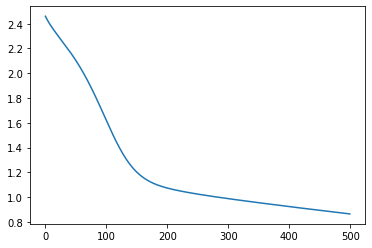

In [ ]:
# Loss for epoches = 500 
plt.plot(np.arange(epochs), loss)
print('Min loss is {}'.format(min(loss)))

Min loss is 0.556930422782898


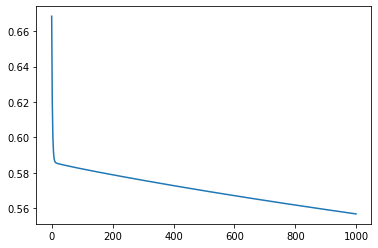

In [ ]:
# Loss for epoches = 1000 
plt.plot(np.arange(epochs), loss)
print('Min loss is {}'.format(min(loss)))

Min loss is 0.4990699291229248


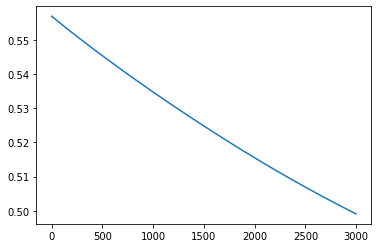

In [ ]:
# Loss for epoches = 5000 
plt.plot(np.arange(epochs), loss)
print('Min loss is {}'.format(min(loss)))

In [ ]:
# Forward prop after training
F_prop = model(in_wm)
f_c = trim(f)+ F_prop

Text(0.5, 0, 'F32')

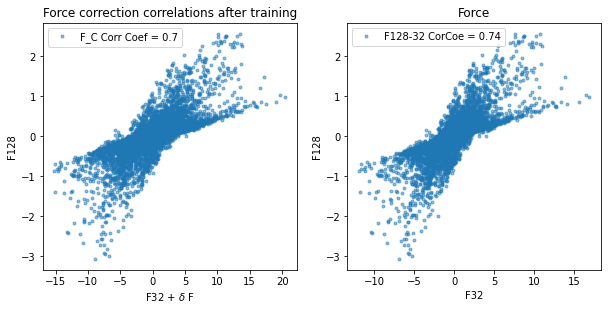

In [ ]:
plt.figure(figsize=(10, 10))

plt.subplot(2,2, 1)
for d in range(1):
    plt.plot(f_c[::, d], trim(fb)[::, d], '.', alpha=0.5,label=f'F_C Corr Coef = {np.round(np.corrcoef(f_c[:, d], trim(fb)[:, d])[0,1],2)}')

plt.title('Force correction correlations after training')
plt.legend()
plt.ylabel('F128')
plt.xlabel('F32 + $\delta$ F')

  
plt.subplot(2,2, 2)
for d in range(1):
    plt.plot(trim(f)[::, d], trim(fb)[::, d], '.', alpha=0.5, label=f'F128-32 CorCoe = {np.round(np.corrcoef(trim(f)[:, d], trim(fb)[:, d])[0,1],2)}' )

plt.title('Force')    
plt.legend()
plt.ylabel('F128')
plt.xlabel('F32')

Text(0.5, 0, 'F32')

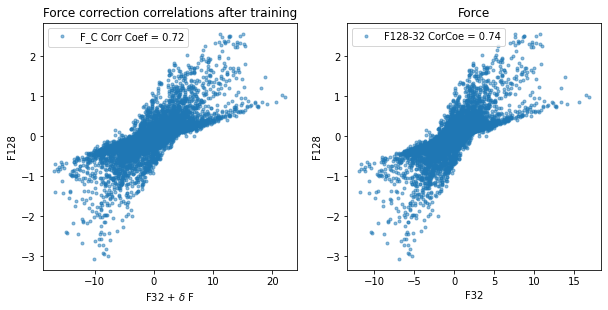

In [ ]:
plt.figure(figsize=(10, 10))

plt.subplot(2,2, 1)
for d in range(1):
    plt.plot(f_c[::, d], trim(fb)[::, d], '.', alpha=0.5,label=f'F_C Corr Coef = {np.round(np.corrcoef(f_c[:, d], trim(fb)[:, d])[0,1],2)}')

plt.title('Force correction correlations after training')
plt.legend()
plt.ylabel('F128')
plt.xlabel('F32 + $\delta$ F')

  
plt.subplot(2,2, 2)
for d in range(1):
    plt.plot(trim(f)[::, d], trim(fb)[::, d], '.', alpha=0.5, label=f'F128-32 CorCoe = {np.round(np.corrcoef(trim(f)[:, d], trim(fb)[:, d])[0,1],2)}' )

plt.title('Force')    
plt.legend()
plt.ylabel('F128')
plt.xlabel('F32')

Text(0.5, 0, 'F32')

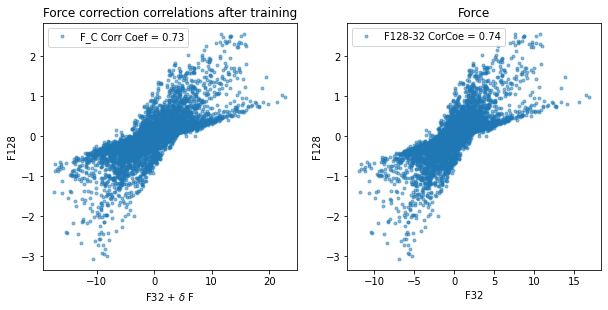

In [ ]:
plt.figure(figsize=(10, 10))

plt.subplot(2,2, 1)
for d in range(1):
    plt.plot(f_c[::, d], trim(fb)[::, d], '.', alpha=0.5,label=f'F_C Corr Coef = {np.round(np.corrcoef(f_c[:, d], trim(fb)[:, d])[0,1],2)}')

plt.title('Force correction correlations after training')
plt.legend()
plt.ylabel('F128')
plt.xlabel('F32 + $\delta$ F')

  
plt.subplot(2,2, 2)
for d in range(1):
    plt.plot(trim(f)[::, d], trim(fb)[::, d], '.', alpha=0.5, label=f'F128-32 CorCoe = {np.round(np.corrcoef(trim(f)[:, d], trim(fb)[:, d])[0,1],2)}' )

plt.title('Force')    
plt.legend()
plt.ylabel('F128')
plt.xlabel('F32')

### In three directions

#### GradientTape along all directions

In [220]:
f_d_b = []
for i in range(batchs):
  f_d = f_b[i]-fb_b[i]
  f_d_b.append(f_d)
#f_d.shape

In [221]:
f_d_b

[<tf.Tensor: shape=(1, 32768, 3), dtype=float32, numpy=
 array([[[ 1.7185452 ,  0.2475133 ,  1.4683119 ],
         [ 1.9812127 ,  0.25812483,  1.289983  ],
         [ 2.6916435 ,  0.23488188,  1.0966741 ],
         ...,
         [ 0.14387874,  0.12890236, -0.37975162],
         [ 0.54762983,  0.07150915,  0.36643   ],
         [ 1.1163676 ,  0.20971602,  1.2128104 ]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 32768, 3), dtype=float32, numpy=
 array([[[-0.45355755,  0.83510315, -0.31813592],
         [-0.15243159,  0.8182939 , -0.4699225 ],
         [-0.10617001,  0.6073811 , -0.42265692],
         ...,
         [-3.4804585 , -0.4236271 , -0.01070147],
         [-3.2921655 , -0.6585643 , -0.1228822 ],
         [-2.4863575 , -0.4131891 , -0.45230138]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 32768, 3), dtype=float32, numpy=
 array([[[-1.2199135 , -0.18645932, -1.0520407 ],
         [-0.92798454,  0.12625718, -0.7156976 ],
         [-0.6979836 ,  0.43300763, -0.49247128],
         ...,
  

In [243]:
# Optimizer
optimizer = tf.keras.optimizers.SGD(1e-3)
# Loss Fn
loss_fn = losses.MeanSquaredError()
#batch_size = 1

#Training dataset

x_train, y_train = in_wm, f_d_b

#train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
#train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)



In [240]:
y_train[0][0]

<tf.Tensor: shape=(32768, 3), dtype=float32, numpy=
array([[ 1.7185452 ,  0.2475133 ,  1.4683119 ],
       [ 1.9812127 ,  0.25812483,  1.289983  ],
       [ 2.6916435 ,  0.23488188,  1.0966741 ],
       ...,
       [ 0.14387874,  0.12890236, -0.37975162],
       [ 0.54762983,  0.07150915,  0.36643   ],
       [ 1.1163676 ,  0.20971602,  1.2128104 ]], dtype=float32)>

In [230]:
for j in range (3):
  m = np.random.randint(2)
  print(m)

0
1
0


In [223]:
model(x_train[0])

<tf.Tensor: shape=(32768, 3), dtype=float32, numpy=
array([[ 0.15480196,  0.25726113,  0.13350423],
       [ 0.10032104,  0.18121277, -0.0884449 ],
       [ 0.1314196 ,  0.18744561, -0.1495413 ],
       ...,
       [ 0.14445765,  0.17371204,  0.03082364],
       [ 0.19836183,  0.12548068, -0.09949493],
       [ 0.22983271,  0.15055822, -0.14263624]], dtype=float32)>

In [244]:
epochs   = 50
loss     = []

for epoch in range(epochs):
  #print("\nStart of epoch %d" % (epoch,))
   #for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
    batch_no = np.random.randint(3)
    y_t =  y_train[batch_no]
    x_t =  x_train[batch_no]
  
    with tf.GradientTape() as tape:
        pred = model(x_t, training=True)
 
        loss_value = loss_fn(y_t[0], pred)
        loss.append(loss_value)

    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))


Min loss is 0.7833356857299805


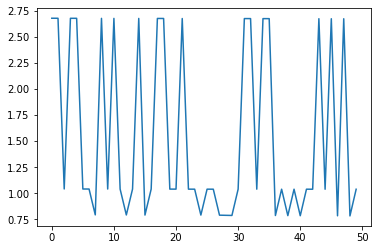

In [245]:
# Loss for epoches = 1000 
plt.plot(np.arange(epochs), loss)
print('Min loss is {}'.format(min(loss)))

Min loss is 0.8072602152824402


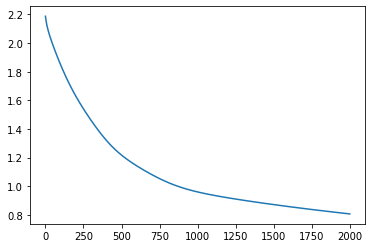

In [ ]:
# Loss for epoches = 2000
plt.plot(np.arange(epochs), loss)
print('Min loss is {}'.format(min(loss)))

Min loss is 1.8386528491973877


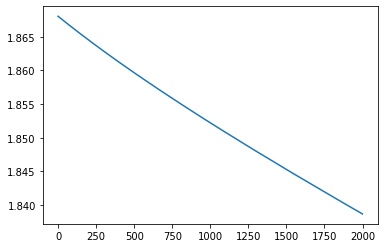

In [ ]:
# Loss for epoches = 5000 
plt.plot(np.arange(epochs), loss)
print('Min loss is {}'.format(min(loss)))

In [ ]:
# Forward prop after training
F_prop = model(in_wm)
f_c = trim(f)+ F_prop

In [ ]:
F_prop

<tf.Tensor: shape=(32768, 3), dtype=float32, numpy=
array([[ 0.17544894,  0.06298864, -0.2067023 ],
       [ 0.40492296, -0.16861127, -0.09906439],
       [ 0.41405907, -0.17375064, -0.08878765],
       ...,
       [ 0.23895983,  0.08511628, -0.21575642],
       [ 0.16323346,  0.03875478, -0.11833043],
       [ 0.15127742, -0.04361704, -0.17956895]], dtype=float32)>

In [ ]:
trim(f)

(array([3.00000e+00, 2.00000e+00, 2.00000e+00, 0.00000e+00, 0.00000e+00,
        4.00000e+00, 8.00000e+00, 3.00000e+00, 3.00000e+00, 6.00000e+00,
        4.00000e+00, 8.00000e+00, 5.00000e+00, 1.10000e+01, 1.70000e+01,
        2.20000e+01, 2.30000e+01, 2.10000e+01, 2.20000e+01, 3.70000e+01,
        3.30000e+01, 5.50000e+01, 8.10000e+01, 9.80000e+01, 1.15000e+02,
        1.37000e+02, 1.88000e+02, 2.37000e+02, 3.25000e+02, 3.99000e+02,
        5.32000e+02, 7.33000e+02, 1.00200e+03, 1.24700e+03, 1.83800e+03,
        2.51600e+03, 3.58700e+03, 5.14100e+03, 7.64500e+03, 1.10040e+04,
        1.58160e+04, 2.28280e+04, 3.26590e+04, 4.47780e+04, 6.23220e+04,
        8.18310e+04, 9.88370e+04, 1.15555e+05, 1.10846e+05, 9.51100e+04,
        7.71460e+04, 5.60160e+04, 3.92920e+04, 2.75100e+04, 1.89200e+04,
        1.28500e+04, 9.02800e+03, 6.47600e+03, 4.76700e+03, 3.36900e+03,
        2.42600e+03, 1.89800e+03, 1.29700e+03, 9.56000e+02, 7.08000e+02,
        5.35000e+02, 4.33000e+02, 3.23000e+02, 2.45

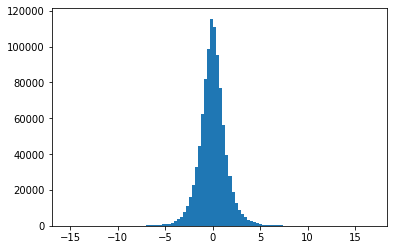

In [ ]:
plt.hist(trim(f-fb).numpy().flatten(), bins =100)

In [ ]:
f_c

<tf.Tensor: shape=(327680, 3), dtype=float32, numpy=
array([[ 1.6816285 ,  4.359315  ,  2.3923216 ],
       [ 1.0898763 ,  3.3264709 ,  1.3295021 ],
       [ 0.9348235 ,  2.5815284 ,  0.51120013],
       ...,
       [-4.653969  , -0.20213714,  4.7909493 ],
       [-6.307964  ,  1.8080709 ,  2.3057666 ],
       [-4.8247967 ,  1.7522194 ,  0.8083948 ]], dtype=float32)>

In [ ]:
from sklearn.utils import shuffle

In [ ]:
xx = np.array([[0, 0, 0], [1, 1, 1], [2, 2, 2], [3, 3, 3], [4, 4, 4]])
yy = np.array([0, 1, 2, 3, 4])
shuffle(xx,yy)

[array([[0, 0, 0],
        [1, 1, 1],
        [3, 3, 3],
        [4, 4, 4],
        [2, 2, 2]]), array([0, 1, 3, 4, 2])]

Text(0.5, 0, 'F32')

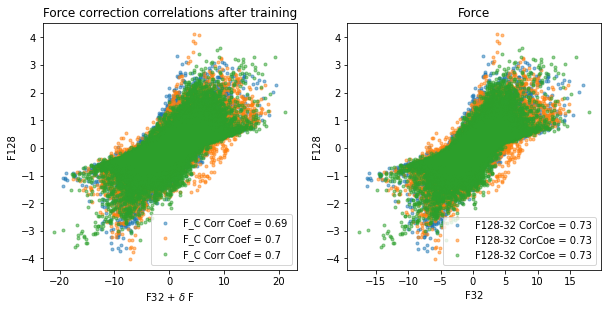

In [ ]:
plt.figure(figsize=(10, 10))

plt.subplot(2,2, 1)
for d in range(3):
    plt.plot(f_c[::, d], trim(fb)[::, d], '.', alpha=0.5,label=f'F_C Corr Coef = {np.round(np.corrcoef(f_c[:, d], trim(fb)[:, d])[0,1],2)}')

plt.title('Force correction correlations after training')
plt.legend()
plt.ylabel('F128')
plt.xlabel('F32 + $\delta$ F')

  
plt.subplot(2,2, 2)
for d in range(3):
    plt.plot(trim(f)[::, d], trim(fb)[::, d], '.', alpha=0.5, label=f'F128-32 CorCoe = {np.round(np.corrcoef(trim(f)[:, d], trim(fb)[:, d])[0,1],2)}' )

plt.title('Force')    
plt.legend()
plt.ylabel('F128')
plt.xlabel('F32')


In [ ]:
F_prop = model(in_wm)

Text(0.5, 0, 'F32')

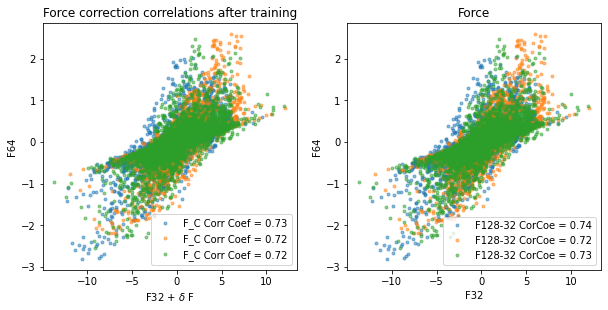

In [ ]:
plt.figure(figsize=(10, 10))

plt.subplot(2,2, 1)
for d in range(3):
    plt.plot(f_c[::, d], trim(fb)[::, d], '.', alpha=0.5,label=f'F_C Corr Coef = {np.round(np.corrcoef(f_c[:, d], trim(fb)[:, d])[0,1],2)}')

plt.title('Force correction correlations after training')
plt.legend()
plt.ylabel('F64')
plt.xlabel('F32 + $\delta$ F')

  
plt.subplot(2,2, 2)
for d in range(3):
    plt.plot(trim(f)[::, d], trim(fb)[::, d], '.', alpha=0.5, label=f'F128-32 CorCoe = {np.round(np.corrcoef(trim(f)[:, d], trim(fb)[:, d])[0,1],2)}' )

plt.title('Force')    
plt.legend()
plt.ylabel('F64')
plt.xlabel('F32')


In [ ]:
F_prop = model(in_wm)

Text(0.5, 0, 'F32')

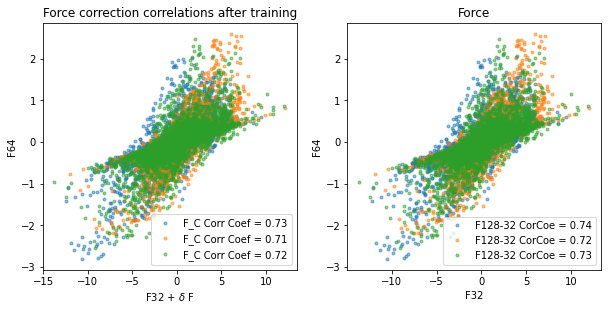

In [ ]:
plt.figure(figsize=(10, 10))

plt.subplot(2,2, 1)
for d in range(3):
    plt.plot(f_c[::, d], trim(fb)[::, d], '.', alpha=0.5,label=f'F_C Corr Coef = {np.round(np.corrcoef(f_c[:, d], trim(fb)[:, d])[0,1],2)}')

plt.title('Force correction correlations after training')
plt.legend()
plt.ylabel('F64')
plt.xlabel('F32 + $\delta$ F')

  
plt.subplot(2,2, 2)
for d in range(3):
    plt.plot(trim(f)[::, d], trim(fb)[::, d], '.', alpha=0.5, label=f'F128-32 CorCoe = {np.round(np.corrcoef(trim(f)[:, d], trim(fb)[:, d])[0,1],2)}' )

plt.title('Force')    
plt.legend()
plt.ylabel('F64')
plt.xlabel('F32')